In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
def read_data(filename):
	with open(filename, mode='r') as f:
		weight = []
		value = []
		num_items = 0

		while True:
			item = f.readline()

			if item:
				items = item.split('\t')
				weight.append(int(items[1]))
				value.append(int(items[2][:-1])) # omit '\n'
				num_items += 1
			else:
				break

	return weight, value, num_items

In [ ]:
class Knapsack:
	def __init__(self, weight, value, num_items, weight_capacity, crossover_prob, crossover_points, mutation_prob,
				 population_size, num_generations, selection_algorithm):
		self.weight = weight
		self.value = value
		self.num_items = num_items
		self.weight_capacity = weight_capacity
		self.crossover_prob = crossover_prob
		self.crossover_points = crossover_points
		self.mutation_prob = mutation_prob
		self.population_size = population_size
		self.num_generations = num_generations
		self.selection_algorithm = selection_algorithm

	def init_population(self):
		return np.random.randint(0, 2, (2*self.population_size, self.num_items)) # 200x500

	def fitness(self, weight, value, population):
		'''
		fitness = SUM_{i=1}^{n}{ith_gene*ith_value} if SUM_{i=1}^{n}{ith_gene*ith_weight}<=(weight_capacity) else 0
		'''
		fitness = {}
		for i in range(population.shape[0]):
			fit = np.sum(population[i] * value) if np.sum(population[i] * weight) <= self.weight_capacity else 0
			fitness[i] = fit
		return fitness

	def selection_rws(self, fitness, population):
		# Roulette wheel selection
		fitness_values = list(fitness.values())
		probability = np.array(fitness_values) / np.sum(fitness_values)
		pick = np.random.choice(list(fitness.keys()), self.population_size, p=probability)
		return population[pick]

	def selection_pwts(self, fitness, population):
		# Pair-wise tournament selection
		pick = []
		for i in range(0, population.shape[0], 2):
			if fitness[i] > fitness[i+1]:
				pick.append(i)
			else:
				pick.append(i+1)
		return population[pick]

	def crossover(self, parents):
		# 3-point crossover
		children = np.empty((self.population_size*2, self.num_items))
		crossover_points = sorted(random.sample(range(self.num_items), self.crossover_points))

		for i in range(0, self.population_size*2, 2):
			idx = np.random.choice(parents.shape[0], 2, replace=False)

			if random.random() < self.crossover_prob:
				children[i, :crossover_points[0]] = parents[idx[0], :crossover_points[0]]
				children[i, crossover_points[0]:crossover_points[1]] = parents[idx[1], crossover_points[0]:crossover_points[1]]
				children[i, crossover_points[1]:crossover_points[2]] = parents[idx[0], crossover_points[1]:crossover_points[2]]
				children[i, crossover_points[2]:] = parents[idx[1], crossover_points[2]:]

				children[i+1, :crossover_points[0]] = parents[idx[1], :crossover_points[0]]
				children[i+1, crossover_points[0]:crossover_points[1]] = parents[idx[0], crossover_points[0]:crossover_points[1]]
				children[i+1, crossover_points[1]:crossover_points[2]] = parents[idx[1], crossover_points[1]:crossover_points[2]]
				children[i+1, crossover_points[2]:] = parents[idx[0], crossover_points[2]:]
		return children

	def mutation(self, children):
		# bit-wise mutation
		for i in range(children.shape[0]):
			for j in range(children.shape[1]):
				if random.random() < self.mutation_prob:
					children[i, j] = 1 - children[i, j]
		return children

	def run(self):
		fitness_history =[]
		population = self.init_population() # 200x500

		for _ in range(self.num_generations):
			fitness = self.fitness(self.weight, self.value, population) # 200
			fitness_history.append(list(fitness.values()))
			if self.selection_algorithm == 'rws':
				parents = self.selection_rws(fitness, population) # 100x500
			elif self.selection_algorithm == 'pwts':
				parents = self.selection_pwts(fitness, population) # 100x500
			children = self.crossover(parents) # 200x500
			population = self.mutation(children) # 200x500

		fitness_last_gen = self.fitness(self.weight, self.value, population)
		max_fitness = np.where(list(fitness_last_gen.values()) == np.max(list(fitness_last_gen.values())))
		parameters = population[max_fitness[0][0]]
		return parameters, fitness_history

Selected items: [  1   3   6   9  10  11  12  13  14  15  16  17  18  19  20  22  26  28
  29  30  32  37  39  40  41  42  43  44  47  49  51  52  53  54  60  63
  64  66  69  70  72  73  75  76  77  78  79  81  82  87  88  89  93  94
  95  97  98 100 101 102 103 106 111 113 114 116 119 120 121 123 124 127
 128 131 133 134 135 136 139 142 144 145 148 151 152 153 155 157 158 159
 162 164 165 166 169 171 176 177 179 181 183 186 188 190 191 192 197 202
 205 207 208 209 210 211 213 215 217 228 235 238 240 242 243 245 247 249
 251 255 256 259 260 261 262 264 265 267 269 270 274 275 276 277 278 281
 282 283 284 285 287 288 290 291 293 294 297 298 301 302 304 307 308 310
 311 312 313 316 319 321 322 324 325 327 329 331 332 334 335 338 341 342
 345 349 350 351 354 356 357 358 359 360 361 365 366 367 369 375 377 378
 382 383 384 388 389 393 394 395 398 405 406 408 409 412 415 416 417 418
 420 422 423 425 426 428 431 432 434 435 443 445 446 447 451 453 454 459
 460 462 463 465 466 467 468 469 47

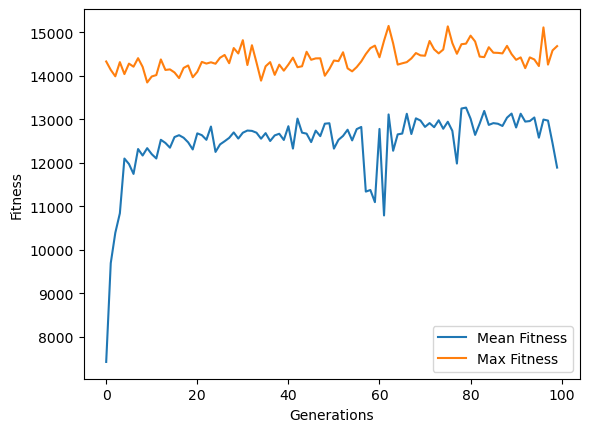

In [ ]:
weight, value, num_items = read_data('data/test.txt')
knapsack = Knapsack(weight,
					value,
					num_items,
					weight_capacity=13743,
					crossover_prob=0.9,
					crossover_points=3,
					mutation_prob=0.01,
					population_size=100,
					num_generations=100,
					selection_algorithm='rws') # rws, pwts
parameters, fitness_history = knapsack.run()
selected_items = np.nonzero(np.arange(num_items) * parameters)[0]
print(f'Selected items: {selected_items}')

# visualize how the fitness changes with every generation
num_generations = 100
fitness_history_mean = [np.mean(fitness) for fitness in fitness_history]
fitness_history_max = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()